# Advanced Microeconometrics 
# d


In [339]:
# automatically reload external modules
%load_ext autoreload
%autoreload 2
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

import tobit as tobit
import estimation
import LinearModels as lm

# automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [340]:
df = pd.read_csv('adv micro data.csv')

y = df['y'].values
X = df['x'].values.reshape(-1,1)

print(df.head())
print(df.shape)

          y         x
0 -2.949143 -0.617175
1  0.000000  0.357731
2 -0.255997  0.600539
3  0.000000  0.123566
4  0.000000 -0.490995
(1000, 2)


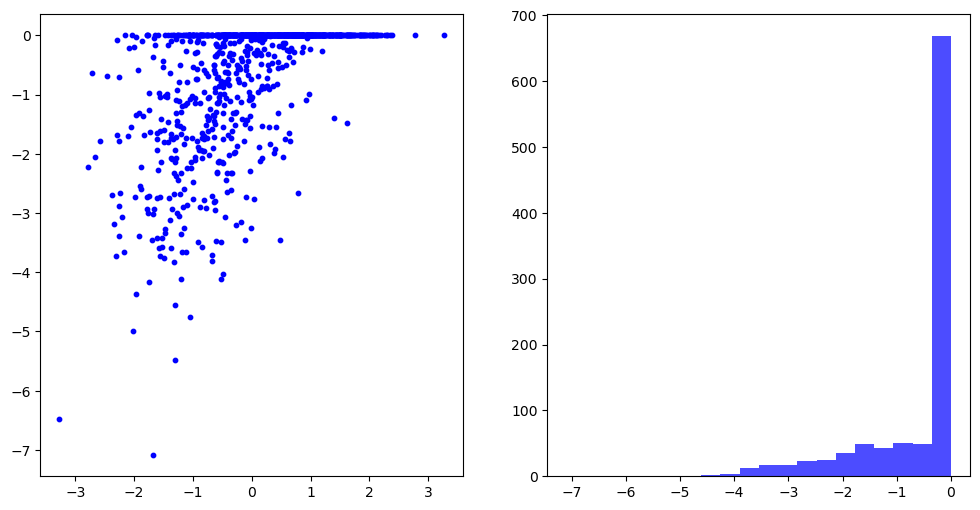

In [341]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].scatter(X, y, s=10, c='b', marker='o', label='Data')
ax[1].hist(y, bins=20, color='b', alpha=0.7, label='Data')

plt.show()

## Question 6: Estimate Tobit Model

$$ 
\ell_i(\theta) = \mathbf{1}\{y_i = 0\} \log\left[\Phi\left(\frac{\mathbf{x}_i \boldsymbol{\beta} + \mu}{\sigma}\right)\right] 
               + \mathbf{1}\{y_i < 0\} \log\left[\frac{1}{\sigma} \phi\left(\frac{y_i - \mathbf{x}_i \boldsymbol{\beta} - \mu}{\sigma}\right)\right] $$


* For the normal CDF and PDF: We use `norm.cdf` and `norm.cdf` from `scipy.stats`
* Since we are taking logs, it is good practice to ensure that we are not taking log of zero. Thus, we use `np.clip(vec, 1e-8, 1.0-1e-8)`, for example, to ensure that `vec` is within $[0.00000001; 0.99999999]$
* We force `sigma` to remain positive during estimation by taking `np.abs(sigma)` when unpacking parameters (in `loglikelihood`, e.g.)


In [342]:
theta0 = tobit.starting_values(y, np.hstack((X,np.ones((X.shape[0],1)))))
# theta0 = np.array([100,100,100])

HOOL


In [343]:
# call the loglikelihood function 
ll0 = tobit.loglikelihood(theta0, y, X)


In [356]:
res_2step = estimation.estimate(tobit.q_re, theta0, y, X, cov_type='Outer Product', method='Nelder-Mead')

/Users/asbjornfyhn/Desktop/Adv Micro Econometrics/AME_projects/exam/estimation.py:44: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = optimize.minimize(Q, theta0, options=options, **kwargs)


In [359]:
print(f"Log-likelihood of procedure 1: {np.sum(tobit.loglikelihood_re(res_2step['theta'], y, X))}")
delta, rho, gamma = res_2step['theta'][0], res_2step['theta'][1], res_2step['theta'][2]
print(delta, rho, gamma)
theta = np.array([delta/gamma, rho/gamma, 1/gamma])     
print(f"Log-likelihood of procedure 2: {np.sum(tobit.loglikelihood(theta, y, X))}")
theta

Log-likelihood of procedure 1: 18259.432888878844
0.8528518100860873 0.37833076463572857 4.7535875971807445e+20
Log-likelihood of procedure 2: -inf


/Users/asbjornfyhn/Desktop/Adv Micro Econometrics/AME_projects/exam/tobit.py:26: RuntimeWarning: divide by zero encountered in log
  


array([1.79412242e-21, 7.95884702e-22, 2.10367429e-21])

In [361]:
res = estimation.estimate(tobit.q, theta0, y, X, cov_type='Outer Product', method='Nelder-Mead')

Optimization terminated successfully.
         Current function value: 1.006679
         Iterations: 70
         Function evaluations: 127


Print results out in a neat table 

In [362]:
delta, rho, gamma = res['theta'][0], res['theta'][1], res['theta'][2]


# Choosing which procedure to use

# One step procedure
# theta = np.array([delta, rho, gamma])                   
# theta_se = res['se']
# theta_t = res['t']

# Two step procedure
theta = np.array([delta/gamma, rho/gamma, 1/gamma])     
theta_se = (None, None, None)
theta_t = (None, None, None)
theta

print(f"Log-likelihood of procedure 1: {np.sum(tobit.loglikelihood(res['theta'], y, X))}, procedure 2: {np.sum(tobit.loglikelihood(theta, y, X))}")

Log-likelihood of procedure 1: -1006.6794260113902, procedure 2: -1690.867682421378


In [346]:
result_dict = {'thetahat': theta,
               'sd': theta_se, 
              't': theta_t}
lab_theta = ['x1', 'mu', 'sigma']

pd.DataFrame(result_dict, index=lab_theta).round(3)

,thetahat,sd,t
x1,0.935,None,None
mu,0.353,None,None
sigma,0.651,None,None


#### Calculate the predicted values of y and the residuals

$$
y^*_i = \mathbf{x}_i \boldsymbol{\hat{\beta}} + \hat{\mu} \\
$$

In [347]:
yPred = tobit.predict(theta, X)

(1000,)


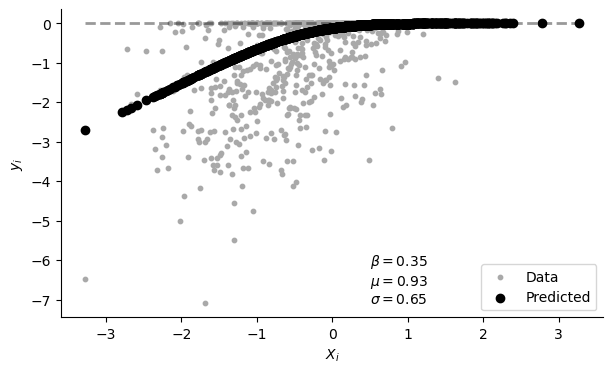

In [348]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.hlines(y=0, xmin=X.min(), xmax=X.max(), color='black', linewidth=2, linestyle='--',alpha=0.4)

ax.scatter(X, y, s=10,  marker='o', label='Data', color='darkgrey')
ax.scatter(X, yPred,  label='Predicted', color='black', marker=None, linestyle='-', linewidth=1)
ax.set_xlabel('$X_i$')
ax.set_ylabel('$y_i$')
ax.legend(loc='lower right')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(0.5, y.min(), s=f'$\\beta = {theta[1]:.2f}$\n$\\mu = {theta[0]:.2f}$\n$\\sigma = {theta[2]:.2f}$',)

plt.show()

#### Marginal effects
We derived the conditional mean of the observable $Y_i$ on $X_i=x$ for the Tobit model in the previous question.

$$
\begin{align*}
E(Y_i|X_i=x)= \left[1-\Phi\left(\frac{\beta_0x+\mu_0}{\sigma_0}\right)\right] \left[ \beta_0 X_i + \mu_0 \right] -
    \sigma_0 \phi\left(\frac{(\beta_0x+\mu_0)}{\sigma_0}\right)
\end{align*}
$$

In order to determine if the partial effect is constant across $X_i$, we derive the partial effect on the conditional mean as: 
$$
\frac{\partial E(Y_i|X_i=x)}{\partial X_i} = \beta \left( 1-\Phi \left( \frac{\beta x + \mu}{\sigma}  \right) \right)
$$

We then conduct run OLS on the above equation to see whether there is a significant relationship between the partial effect and $X_i$. Thus if  has constant partial eﬀect on the conditional mean that must mean that $\beta>0$.

The null-hypothesis is that $\beta=0$ and the alternative hypothesis is that $\beta\ne0$.

 


In [ ]:
from scipy.stats import norm
def marginal_effect(x, b, mu, sigma):
    b = b.reshape(-1,1)
    inner = (x@b + mu )/ sigma 
    return (1-norm.cdf(inner))*(x@b+mu) - sigma*norm.pdf(inner)

beta, mu, sigma = res['theta']

step = 1.49e-08
marginal_effect(X, np.array((beta)), mu, sigma)

x1 = np.copy(X) 
x_1 = np.copy(X)

x1[:,0] = x1[:,0] + step
x_1[:,0] = x_1[:,0] - step

grad = marginal_effect(x1, np.array((beta)), mu, sigma) - marginal_effect(x_1, np.array((beta)), mu, sigma)
grad *= 1/(step*2)


In [394]:
analytical_grad = beta * (1-norm.cdf((X@beta.reshape(-1,1) + mu)/sigma) )

In [443]:
# OLS estimation of analytical_grad on X
ols_est = lm.estimate(analytical_grad, np.hstack((np.ones((X.shape[0],1)), X )), transform='',t=None, robust_se=True)

ols_X = np.linspace(X.min(), X.max(), 1000).reshape(-1,1)

ols_line = np.hstack((np.ones((ols_X.shape[0],1)), ols_X))@ols_est['b_hat']

ols_est

{'b_hat': array([[ 0.57071984],
        [-0.38646956]]),
 'se': array([0.00258593, 0.00467325]),
 'sigma2': array([[0.00643986]]),
 't_values': array([[ 220.70154154,  122.12470321],
        [-149.45060871,  -82.69815927]]),
 'R2': array([[0.95908172]]),
 'cov': array([[6.68705976e-06, 5.82103708e-06],
        [5.82103708e-06, 2.18393091e-05]])}

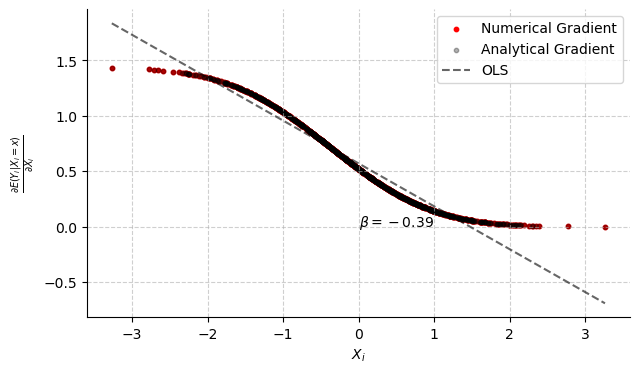

In [442]:
fig, ax = plt.subplots(1,1, figsize=(7,4))

ax.scatter(X, grad, s=10,  marker='o', label='Numerical Gradient', color='red')
ax.scatter(X, analytical_grad, s=10,  marker='o', label='Analytical Gradient', color='black',linestyle='-', linewidth=1, alpha=0.3)

# add ols line
ax.plot(np.linspace(X.min(), X.max(), 1000), ols_line, label='OLS', color='black', linestyle='--', alpha=0.6)

# add text showing the estimated coefficient
ax.text(0.0, grad.min(), s=f'$\\beta = {ols_est["b_hat"][1][0]:.2f}$',)
ax.legend(loc='upper right')


# Remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# ylabel and xlabel
ax.set_ylabel('$\\frac{\partial E(Y_i|X_i=x)}{\partial X_i}$')
ax.set_xlabel('$X_i$')

# gridlines
ax.grid(True, linestyle='--', alpha=0.6)

plt.show()

fig.savefig('marginal_effect.png', dpi=300)
